Author: Gurjeet Singh (gurjeet.singh@helsinki.fi)


# Distributional approximations for Poisson-gamma

$$x_n \sim Poisson(uv), \quad u \sim Gamma(5, 1), \quad v \sim Gamma(4,4)$$

$x_n$ are conditionally independent of each other

The joint log probability is: 

$$ \log p(X,u,v) = \sum_i \left [ x_i \log u + x_i \log v - uv - \log x_i! \right ] $$ 
$$\quad\quad\quad + \alpha_u \log \beta_u - \log \Gamma(\alpha_u) + (\alpha_u - 1)\log u - \beta_u u $$
$$\quad\quad\quad + \alpha_v \log \beta_v - \log \Gamma(\alpha_v) + (\alpha_v - 1)\log v - \beta_v v $$

## Laplace approximation

$$ \frac{d\; log p(X, u,v)}{du^2 } = \sum_{i} \left( -\frac{x_i}{u^2} \right) - \frac{4}{u^2} $$
$$ \frac{d\; log p(X, u,v)}{duv } = -N $$
$$ \frac{d\; log p(X, u,v)}{dv^2 } = \sum_{i} \left( -\frac{x_i}{v^2} \right) - \frac{3}{v^2} $$
$$\frac{d\; log p(X, u,v)}{dvu } = -N $$

After estimating the $v$ and $u$ we calculate the negative hessian with the estimated values from MAP.

$$ -\mathcal{H} =  
\begin{bmatrix} 
\sum_{i} \left( \frac{x_i}{u^2} \right) + \frac{4}{u^2}  & N \\
    N &  \sum_{i} \left( \frac{x_i}{v^2} \right)  \frac{3}{v^2}
\end{bmatrix}$$

In [186]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import torch
import torch.distributions as dist
import os
import time
os.environ['KMP_DUPLICATE_LIB_OK']='True'


np.random.seed(13)
# Define the same model as for MCMC
prior_u_alpha, prior_u_beta = (5., 1.)
prior_v_alpha, prior_v_beta = (4., 4.)

u_prior = dist.gamma.Gamma(torch.tensor([prior_u_alpha]), torch.tensor([prior_u_alpha]))
v_prior = dist.gamma.Gamma(torch.tensor([prior_v_alpha]), torch.tensor([prior_v_alpha]))

# Re-use same data
x = torch.tensor([3, 4, 3, 9, 10, 3, 2, 3, 3, 2])
N=10

def log_posterior(data, u, v):
    likelihood = dist.Poisson(u*v)
    return torch.sum(likelihood.log_prob(data)) + u_prior.log_prob(u) + v_prior.log_prob(v)


In [2]:
# First find the best point estimate, parameterizing precision in log-domain
u = torch.nn.Parameter(torch.as_tensor(3.0))
v = torch.nn.Parameter(torch.as_tensor(.5))

tic = time.perf_counter()
optimizer = torch.optim.SGD({u, v}, lr=1e-3)
for iter in range(200):
    loss = -log_posterior(x, u, v)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

def lossForHessian(param):
    return -log_posterior(x, param[0], param[1])

#negative Hessian
def get_hessian(x, param):
    u = param[0]
    v = param[1]
    return torch.tensor([[torch.sum(x / u.pow(2)) + 4./v.pow(2), N],
                  [N , torch.sum(x / v.pow(2)) + 3./u.pow(2)]])
    
    
param = torch.tensor([u.item(), v.item()])
H = get_hessian(x, param)

# Form the actual approximation
laplace = dist.multivariate_normal.MultivariateNormal(torch.tensor([u, v]), precision_matrix=H)
laplace_u = dist.normal.Normal(u, scale=1.0/torch.sqrt(H[0,0]))
laplace_v = dist.normal.Normal(v, scale=1.0/torch.sqrt(H[1,1]))

toc = time.perf_counter()
print("MAP estimate for u:",)
print(" mean : ", laplace_u.mean.detach().numpy())
print(" std : ", laplace_u.scale.detach().numpy())
print("MAP estimate for v: ", )
print(" mean : ", laplace_v.mean.detach().numpy())
print(" std : ", laplace_v.scale.detach().numpy())

print(" Time passed for the Laplace Approximation method: ", toc-tic)
def Gibbs(x, u, v, T):
    # Storage for samples
    samples = [u, v]
    sumx = sum(x)
    N = len(x)
    for t in range(T):
        # Sample u conditional on v and data
        log_lambda_term = sumx + prior_u_alpha
        lambda_term = N*v + prior_u_beta
        u = np.random.gamma(log_lambda_term, scale = 1.0 / lambda_term)
        
        # Sample v conditional on u and data
        log_lambda_term = sumx + prior_v_alpha
        lambda_term = N*u + prior_u_beta
        v = np.random.gamma(log_lambda_term, scale = 1.0 / lambda_term)

        samples = np.vstack([samples, [u, v]])
    return samples

print("Gibbs samples run")

tic = time.perf_counter()
gibbs_samples = Gibbs(x, 3.0, 0.5, 2000)
toc = time.perf_counter()

print(" mean u: ", np.mean(gibbs_samples[500:,0]))
print(" variance u: ", np.var(gibbs_samples[500:,0]))
print(" mean v: ", np.mean(gibbs_samples[500:,1]))
print(" variance v: ", np.var(gibbs_samples[500:,1]))
print(" Time passed for the Gibbs sampler: ", toc-tic)

MAP estimate for u:
 mean :  2.6992931
 std :  0.35852754
MAP estimate for v: 
 mean :  1.4088619
 std :  0.21530743
 Time passed for the Laplace Approximation method:  1.001434488000001
Gibbs samples run
 mean u:  2.8247328054222303
 variance u:  1.6605064866648005
 mean v:  1.888846281720226
 variance v:  0.828563344987273
 Time passed for the Gibbs sampler:  0.4460651169999963


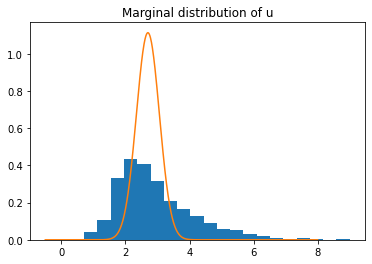

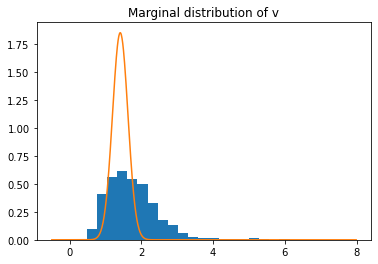

In [3]:
# Marginal distribution for u
ind = torch.tensor(np.arange(-0.5, 8.0, 0.01),dtype=torch.double)
plt.hist(gibbs_samples[1000:,0], bins=20, density=True)
plt.plot(ind, torch.exp(laplace_u.log_prob(ind)).detach())
plt.title("Marginal distribution of u")
plt.show()

# Marginal distribution for v
ind = torch.tensor(np.arange(-0.5, 8, 0.01),dtype=torch.double)
plt.hist(gibbs_samples[1000:,1], bins=20, density=True)
plt.plot(ind, torch.exp(laplace_v.log_prob(ind)).detach())
plt.title("Marginal distribution of v")
plt.show()

From the plot above we can see that the Laplace approximation is able to capture approximately the distribution of the data. The marginals distritbution show a good summary of the estimated parameter, indeed they quantify the uncertainty quite close to the mean, close to the gibbs sampler estimation.
In addition it requires less iterations to achieve the final result. However, the Laplace approximation method takes more computational time for the same amount of iterations used with the Gibbs sampler.

## Mean-field variational Approximation
$$
q(u,v \vert \lambda) \approx q(u \vert a, b) \; q(v \vert c, d) $$
$$ q_u \approx \exp \left(\mathbf{E}_{q_v}\left[ log(q(u \vert v, X) \right]\right), \quad q_v \approx \exp \left(\mathbf{E}_{q_u}\left[ log(q(v \vert u, X) \right]\right) $$
$$\mathbf{E}_{q_v}\left[ log(q(u \vert v, X) \right] = C + \left( \left( \alpha_u + \sum_i x_i \right) -1 \right) log(u) - \left( \mathbf{E}_{q_v} \left[nv \right] + \beta_u\right) u $$
$$\mathbf{E}_{q_v} \left[nv \right] = \frac{c}{d} $$
$$\mathbf{E}_{q_v}\left[ log(q(u \vert v, X) \right] \sim Gamma(\alpha_u + \sum_i x_i,\; N \frac{c}{d} + \beta_u)$$
$$\mathbf{E}_{q_u}\left[ log(q(v \vert u, X) \right] = C + \left( \left( \alpha_v + \sum_i x_i \right) -1 \right) log(v) - \left( \mathbf{E}_{q_u} \left[nu \right] + \beta_v\right) v$$
$$\mathbf{E}_{q_u} \left[nu \right] = \frac{a}{b} $$
$$\mathbf{E}_{q_v}\left[ log(q(v \vert u, X) \right] \sim Gamma(\alpha_v + \sum_i x_i,\; N \;\frac{a}{b} + \beta_v)
$$

In [4]:
from scipy.special import digamma

# Reuse the same data
if(isinstance(x, torch.Tensor)):
    x = x.numpy()

# Define the same model as for MCMC
prior_u_alpha, prior_u_beta = (5., 1.)
prior_v_alpha, prior_v_beta = (4., 4.)

# Priors
u_prior = stats.gamma(prior_u_alpha, scale=1./prior_u_beta)
v_prior = stats.gamma(prior_v_alpha, scale=1./prior_v_beta)
    
# Define the model again in numpy
#mean_prior = stats.norm(prior_mu, prior_sigma)
#prec_prior = stats.gamma(prior_alpha, scale=1.0/prior_beta)

def log_posterior(data, u, v):
    likelihood = stats.poisson(u*v)
    return np.sum(likelihood.logpmf(data)) + u_prior.logpdf(u) + v_prior.logpdf(v)

# Definte the approximation
q_u_param = [prior_u_alpha + x.sum(), 1.0]
q_v_param = [prior_v_alpha + x.sum(), 4.0]
q_u = stats.gamma(q_u_param[0], scale=1.0/q_u_param[1]) 
q_v = stats.gamma(q_v_param[0], scale=1.0/q_v_param[1])

tic = time.perf_counter()
for iter in range(10):
    # Update q_u
    E_qv = q_v.mean()
    # Update the parameters
    x_sum = x.sum()
    lenx = len(x)
    
    q_u_param[0] = prior_u_alpha + x_sum
    q_u_param[1] = lenx * E_qv + prior_u_beta
    q_u = stats.gamma(q_u_param[0], scale=1.0/q_u_param[1])
    
    ### Update q_v
    # Compute required expectations
    E_qu = q_u.mean()
    
    # Update the parameters
    q_v_param[0] = prior_v_alpha + x_sum
    q_v_param[1] = lenx * E_qu + prior_v_beta
    q_v = stats.gamma(q_v_param[0], scale=1.0/q_v_param[1])
    # Here we could (and should) evaluate the objective -- try implementing it!
toc = time.perf_counter()

Parameters of q_u:  [47.0, 14.090446157973092]
 Mean: 3.3355934562373672
 Std: 0.48654631113449626
Parameters of q_v:  [46.0, 37.355934562373676]
 Mean: 1.2313973814038361
 Std: 0.18155963871819955
 Time passed for the Mean-field variational approximation:  0.22929040000000356



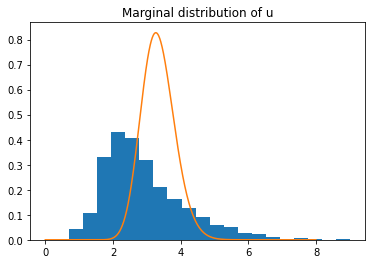

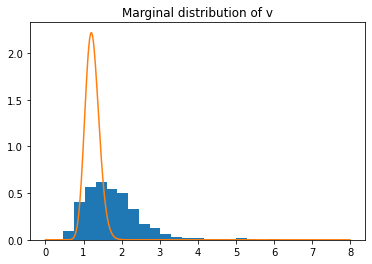

In [5]:
print("Parameters of q_u: ", q_u_param)
print(" Mean:", q_u.mean())
print(" Std:", q_u.std())
print("Parameters of q_v: ", q_v_param)
print(" Mean:", q_v.mean())
print(" Std:", q_v.std())

print(" Time passed for the Mean-field variational approximation: ", toc-tic)
print()

# Marginal distribution for mu
ind = np.arange(0., 8.0, 0.01)
plt.hist(gibbs_samples[1000:,0], bins=20, density=True)
plt.plot(ind, np.exp(q_u.logpdf(ind)))
plt.title("Marginal distribution of u")
plt.show()

# Marginal distribution for prec
ind = np.arange(0, 8., 0.01)
plt.hist(gibbs_samples[1000:,1], bins=20, density=True)
plt.plot(ind, np.exp(q_v.logpdf(ind)))
plt.title("Marginal distribution of v")
plt.show()

How does it differ from the Laplace approximation?

The mean-field variational approximation methods requires only a few iterations to converge at a suboptimal distribution (10 iterations, incontrast of 100 iterations of Laplace method), and it requires less computational time.
However, the resulting distribution differs from the Gibbs marginal posterior. Indeed, by approximating the the posteriors on expectations the parameter are stuck in a suboptimal solution.

The resulted approximation it's also worse than the Laplace approximation method.

# Mixture models
Having:
$$ p(\boldsymbol{\pi} \vert \alpha) = Dirichlet(\alpha) $$
$$ p(\mu_k \vert \tau_0) = \mathcal{N (0, \tau_0)} $$
$$p(\tau_k \vert \alpha_0, \beta_0) = Gamma(\alpha_0, \beta_0) $$
$$ p(z_n \vert \boldsymbol\pi) = Categorical(\boldsymbol\pi)$$
$$ p(x_n \vert \ \mu_{z_n}, \tau_{z_n}, z_n) = \mathcal{N}(\mu_{z_n}, \tau_{z_n}) $$

The log-density is: 

$$
\begin{aligned}
\log &\left[\prod_{n} \prod_{k}\left(p\left(z_{n} \mid \boldsymbol{\pi}\right) p\left(x_{n} \mid \mu_{z_{n}}, \tau_{z_{n}}\right)\right)^{\left.\mathbb{I} z_{n}=k\right]}\right]\left[\prod_{k} p\left(\mu_{k}\right) p\left(\tau_{k}\right)\right] p(\boldsymbol{\pi}) \\
=& \sum_{n} \sum_{k} \mathbb{I}\left[z_{n}=k\right]\left[\log \pi_{k}+\left(-\frac{1}{2} \log (2 \pi)+\frac{1}{2} \log \tau_{d}-\frac{1}{2} \tau_{d}\left(x_{d}-\mu_{d}\right)^{2}\right)\right] \\
&+\sum_{k}\left(-\frac{1}{2} \log (2 \pi)+\frac{1}{2} \log \tau_{0}-\frac{1}{2} \tau_{0} \mu_{k}^{2}+\alpha_{0} \log \left(\beta_{0}\right)-\Gamma\left(\alpha_{0}\right)+\left(\alpha_{0}-1\right) \log \left(\tau_{k}\right)-\beta_{0} \tau_{k}\right) \\
&+\sum_{k}(\alpha-1) \log \pi_{k}-\log B(\alpha)
\end{aligned}
$$

From the log joint density, assuming independent variables, we retrieve the following conditional distributions:
$$
p(\pi_k \mid \boldsymbol{z}, \alpha)=\operatorname{Dirichlet}\left(\alpha+\sum_{n} \mathbb{I}\left[z_{n}=k\right]\right)=\operatorname{Dirichlet}\left(\alpha+N_{k}\right)$$
$$ p\left(\tau_{k} \mid \ldots\right)=\operatorname{Gamma}\left(\alpha_{0}+\frac{1}{2} N_{k}, \beta_{0}+\frac{1}{2} \sum_{n} \mathbb{I}\left(z_{n}=k\right)\left(x_{n}-\mu_{k}\right)^{2}\right)$$
$$ p\left(\mu_{k} \mid \ldots\right)=\mathcal{N}\left(\frac{\tau_{k} \sum_{n} \mathbb{I}\left[z_{n}=k\right] x_{k}}{t_{0}+N_{k} \tau_k}, t_{0}+N_{k} \tau_k\right)$$
$$ p\left(z_{n}=k \mid x_{n}, \ldots\right)=\frac{e^{\nu_{n k}}}{\sum_{j} e^{\nu_{n j}}}$$

To find the posterior latent distribution $q_{\theta}$ we apply the CAVI method.

$$
\begin{aligned}
q(\boldsymbol{z}, \boldsymbol{\pi}, \boldsymbol{\tau}, \boldsymbol{\mu})=\prod_{n}\left[q\left(z_{n} \mid \boldsymbol{\xi}_{n}\right)\right] q(\boldsymbol{\pi} \mid \boldsymbol{\eta}) \prod_{k}\left[q\left(\tau_{k} \mid a_{k}, b_{k}\right) q\left(\mu_{k} \mid m_{k}, t_{k}\right)\right]
\end{aligned}
$$

Each latent distribution present the following update:

Dirichlet Latent distribution $q(\pi_k \vert \cdot))$:
$$
\mathbf{E}_{q_z} q(\pi_k \vert \cdot)) \sim Dirichlet(\alpha_k) \quad \alpha_k = \alpha + \sum_{n} \xi_{nk}
$$

Precision $\tau_k$ with Gamma Latent distribution $q(\tau_k \vert \cdot)$:

$$a_k = \alpha_0 + \frac{1}{2} \sum_{n}\xi_{nk} $$
$$b_k = \beta_0 + \frac{1}{2} \sum_{n} \xi_{nk} \left( x_n^2 - 2x_n m + m^2 + \frac{1}{t}\right)$$
$$\mathbf{E}_{q_z q_\mu} q(\tau_k \vert \cdot) \sim Gamma \left(a_k , \; b_k\right)$$

Mean $\mu_k$ with Normal latent distribution $q(\mu_k \vert \cdot)$:

$$
\begin{aligned}
m_k = \frac{\frac{a_k}{b_k} \sum_{n}(\xi_{nk} \; x_n)}{\tau_0 + \frac{\alpha}{\beta} \sum_{n}\xi_{nk}} \\
t_k = \tau_0 + \frac{a_k}{b_k} \sum_{n}\xi_{nk} \\
\mathbf{E}_{q_z q_\tau} q(\mu_k \vert \cdot) \sim \mathcal{N} \left(m_k, \; t_k \right)
\end{aligned}
$$

Finally the categorical distribution $q_z$ is proportional to $\nu_{nk}$:
$$ \nu_{n k}=\log p\left(z_{n}=k \mid x_{n}, \ldots\right) \propto \log \pi_{k}+\left(-\frac{1}{2} \log (2 \pi)+\frac{1}{2} \log \tau_{k}-\frac{1}{2} \tau_{k}\left(x_{n}-\mu_{k}\right)^{2}\right) $$
$$
\begin{aligned}
\zeta_{nk}  = \mathbf{E}_{q_z q_\tau q_\mu} \left[\log \pi_{k}+\left(-\frac{1}{2} \log (2 \pi)+\frac{1}{2} \log \tau_{k}-\frac{1}{2} \tau_{k}\left(x_{n}-\mu_{k}\right)^{2}\right) \right] \\
\zeta_{nk} = \psi(\alpha_k) - \psi\left(\sum_{k'}\alpha_{k'}\right) + \frac{1}{2}\left(\psi(a_k) - log(b_k) \right) - \frac{a_k}{2b_k}\left(x_n^2 - 2x_n m_k + m_k^2 + \frac{1}{t} \right)
\end{aligned}
$$
$$\xi_{n k} = \frac{\zeta_{n k}}{\sum_{k'}\zeta_{n k'}}$$
$$ q(z_{nk}) \propto  \xi_{n k} $$

Where $\psi$ is the digamma function.



(array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  2.,  2.,  4.,  9., 12.,
        17., 14., 20., 18., 16., 23., 20.,  9.,  8., 12.,  7.,  7.,  9.,
        11., 10., 15., 21., 27., 33., 44., 20., 29., 33., 15., 15.,  4.,
         9.,  5.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]),
 array([-4.        , -3.83673469, -3.67346939, -3.51020408, -3.34693878,
        -3.18367347, -3.02040816, -2.85714286, -2.69387755, -2.53061224,
        -2.36734694, -2.20408163, -2.04081633, -1.87755102, -1.71428571,
        -1.55102041, -1.3877551 , -1.2244898 , -1.06122449, -0.89795918,
        -0.73469388, -0.57142857, -0.40816327, -0.24489796, -0.08163265,
         0.08163265,  0.24489796,  0.40816327,  0.57142857,  0.73469388,
         0.89795918,  1.06122449,  1.2244898 ,  1.3877551 ,  1.55102041,
         1.71428571,  1.87755102,  2.04081633,  2.20408163,  2.36734694,
         2.53061224,  2.69387755,  2.85714286,  3.02040816,  3.18367347,
         3.34693878,  3.51020408,  3.67346939,  3.83673469,  4. 

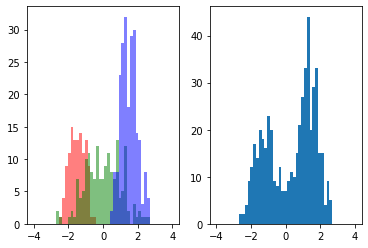

In [311]:
from scipy.special import logsumexp
K = 3; N = 500; x = np.zeros(N)
# True parameters
pi_true = np.array([0.2, 0.35, 0.45])
mu_true = np.array([-1.5, 0. , 1.5])
tau_true = np.array([5., 1.,  5.])

# Ground thruth and plots
z_true = stats.multinomial(1, pi_true).rvs(N)
colors = ['r', 'g', 'b']
plt.subplot(1,2,1)
for k in range(3):
  x[z_true[:,k] == 1 ] = stats.norm(mu_true[k], 1./np.sqrt(tau_true[k])).rvs(sum(z_true[:, k]))
  plt.hist(x[z_true[:, k] ==1], color=colors[k], bins=np.linspace(-4., 4., 50), alpha = 0.5)
plt.subplot(1, 2, 2)
plt.hist(x, bins=np.linspace(-4., 4, 50))

In [312]:
epochs = 200
# priors parameters
alpha, alpha_0, beta_0, tau_0 = ([1]*K, 0.5, 0.5, 0.5) #mu is assumed to be zero
q_z = stats.dirichlet(alpha=100*np.ones(K)).rvs(N)

# latent pdf
q_pi = stats.dirichlet(alpha=100*np.ones(K)).rvs(1).flatten()
q_tau = [stats.gamma(alpha_0, scale=1.0/beta_0)] * K
q_mu = [stats.norm(0, scale=1./np.sqrt(tau_0))] * K

#latent params
q_pi_param = np.zeros(K)
q_tau_param = np.zeros((epochs, K, 2))
q_mu_param = np.zeros((epochs, K, 2))

In [313]:
tic = time.perf_counter()
for iter in range(epochs):
    #for each k model
    for k in range (0, K):
      
      q_z_k = q_z[:, k]
      q_z_k_sum = q_z_k.sum()
      q_z_k_X = (q_z_k * x).sum()
      
      # pi latent dirichlet parameter update
      q_pi_param[k] = alpha[k] + q_z_k_sum

      # tau gamma latent update
      # param gamma a
      q_tau_param[iter, k, 0] =  alpha_0 + 0.5 * q_z_k_sum
      # param gamma b
      E_mu = q_mu[k].mean()
      mu_var = q_mu[k].var()
      q_tau_param[iter, k, 1] = beta_0 + 0.5 *  np.sum(q_z_k * (x** 2 - 2*x*E_mu + E_mu**2 +  mu_var))
      q_tau[k] = stats.gamma(q_tau_param[iter, k, 0], scale=1.0/q_tau_param[iter, k, 1])

      # mu normal latent update
      # param normal prec - tau_0
      E_tau = q_tau[k].mean()
      q_mu_param[iter, k, 1] =  1./tau_0**2 + E_tau * q_z_k_sum
      # param normal mu
      q_mu_param[iter, k, 0] = E_tau * q_z_k_X / q_mu_param[iter, k, 1]
      q_mu[k] = stats.norm(q_mu_param[iter, k, 0], scale=1.0/np.sqrt(q_mu_param[iter, k, 1]))

    # pi dirichlet distribution update
    q_pi = stats.dirichlet(q_pi_param)

    # z categorical latent update
    alphas_sum = np.array(q_pi.alpha).sum()
    for n in range (0, N):
      for k in range (0, K): 
        q_z[n, k] = digamma(q_pi.alpha[k]) - digamma(alphas_sum) + 0.5 * \
                           (digamma(q_tau_param[iter, k, 0]) - np.log(q_tau_param[iter, k, 1])) \
                           -0.5 * q_tau_param[iter, k, 0] / q_tau_param[iter, k, 1] \
                           * (x[n]**2 - 2*x[n]*q_mu[k].mean() + q_mu[k].mean()**2 + q_mu[k].var())
    for n in range (0, N):
        q_z[n] = np.exp(q_z[n] - logsumexp(q_z[n,:]))

toc = time.perf_counter()

print(" Time passed for the Mixture model: ", toc-tic)

 Time passed for the Mixture model:  95.7071485109991


For a fair comparison with the ground thruth we sort the cluster derived from the convergence of the algorithm by sorting them based on the $\mu$ parameters found from the latent normal distribution

In [314]:
idx=np.argsort(q_mu_param[-1, :,0])        
res_q_pi_param = q_pi_param[idx]
res_pi = res_q_pi_param/np.sum(res_q_pi_param)
res_q_mu_param=q_mu_param[-1, idx, :]
res_q_tau_param = q_tau_param[-1, idx, 0] / q_tau_param[-1, idx, 1]
res_q_z=q_z[:, idx]

In [319]:
print("Parameter mu for the normal distribution")
print(" Estimated mu", res_q_mu_param[:, 0])
print(" True mu: ", mu_true)
print("Parameter mean for the gamma distribution")
print(" Estimated tau mean ", res_q_tau_param)
print(" True value ", tau_true)

print("Pi esimated")
print(" ", res_pi)
print("Pi true values", pi_true)

Parameter mu for the normal distribution
 Estimated mu [-1.29160691 -0.03856739  1.37186816]
 True mu:  [-1.5  0.   1.5]
Parameter mean for the gamma distribution
 Estimated tau mean  [3.07735784 1.23462252 3.25833423]
 True value  [5. 1. 5.]
Pi esimated
  [0.33355623 0.11487265 0.55157113]
Pi true values [0.2  0.35 0.45]


In [316]:
classes = np.argmax(res_q_z, axis=1)
true_classes = np.argmax(z_true, axis=1)
class_category = np.zeros((N, K))
true_class_category = np.zeros((N, K))
for i in range(0, N):
  class_category[i, classes[i]] = 1.
  true_class_category[i, true_classes[i]] = 1.

In [317]:
np.sum(classes==true_classes)/N

0.726

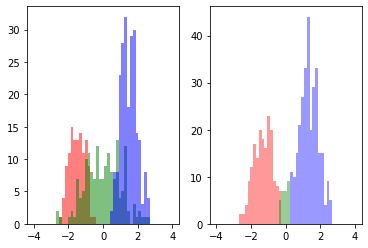

In [318]:
colors = ['r', 'g', 'b']
plt.subplot(1, 2, 1)
for k in range(3):
  plt.hist(x[true_class_category[:, k]==1], color=colors[k], bins=np.linspace(-4., 4., 50), alpha = 0.5)

plt.subplot(1, 2, 2)
for k in range(3):
  plt.hist(x[class_category[:, k]==1], color=colors[k], bins=np.linspace(-4., 4., 50), alpha = 0.4)

The result differs a little bit from the expected one as show in the plot.
There could be some mistakes in the code, even though the analytical derivations should be correct. It could be the initialization of the latent variables or maybe it just require more epochs to converge better at the final solution. From the estimated results we can see that the normal distribution achieve close results to the ground thruth. But the gamma distribution differs with the true parameter. 
Overall the result seems correct we achieve an accuracy of 76\%. Better results could be achieved by tuning better the parameters.